In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# ============================================
# 📌 CELL 0 — SEARCH FOR "eye_project" FOLDER
# ============================================

import os

base = "/content/drive/MyDrive"
print("Scanning:", base)

found_paths = []

for root, dirs, files in os.walk(base):
    if "eye_project" in dirs:
        full_path = os.path.join(root, "eye_project")
        found_paths.append(full_path)

if not found_paths:
    print("\n❌ No folder named 'eye_project' found under MyDrive.")
    print("➡ Check your Google Drive and confirm the exact folder name.")
else:
    print("\n✅ Found the following 'eye_project' folder(s):")
    for p in found_paths:
        print("  ", p)


Scanning: /content/drive/MyDrive

✅ Found the following 'eye_project' folder(s):
   /content/drive/MyDrive/eye_project


In [ ]:
# ============================================
# 📌 CELL 1 — MOUNT DRIVE & CHECK IMPORTANT FILES
# ============================================

from google.colab import drive
from pathlib import Path
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Root paths
ROOT = Path("/content/drive/MyDrive/eye_project")
PROC = ROOT / "processed"
SPLITS = PROC / "splits_strict_10cls_new"

# Key CSVs
TRAIN_AUG_CSV = PROC / "train_augmented.csv"       # from offline augmentation
VAL_CSV       = SPLITS / "val.csv"
TEST_CSV      = SPLITS / "test.csv"

print("ROOT exists:", ROOT.exists())
print("Processed folder exists:", PROC.exists())
print("Splits folder exists:", SPLITS.exists())
print("Augmented train CSV exists:", TRAIN_AUG_CSV.exists())
print("Val CSV exists:", VAL_CSV.exists())
print("Test CSV exists:", TEST_CSV.exists())

# (Optional) quick shapes check if you want
if TRAIN_AUG_CSV.exists():
    train_df = pd.read_csv(TRAIN_AUG_CSV)
    print("Augmented train shape:", train_df.shape)

if VAL_CSV.exists():
    val_df = pd.read_csv(VAL_CSV)
    print("Val shape:", val_df.shape)

if TEST_CSV.exists():
    test_df = pd.read_csv(TEST_CSV)
    print("Test shape:", test_df.shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ROOT exists: True
Processed folder exists: True
Splits folder exists: True
Augmented train CSV exists: True
Val CSV exists: True
Test CSV exists: True
Augmented train shape: (959, 2)
Val shape: (165, 15)
Test shape: (165, 15)


In [ ]:
# ============================================
# 📌 CELL 3 — DATASET + TRANSFORMS + LOADERS
# ============================================

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
import pandas as pd
from pathlib import Path

# ROOT and PROC are already defined in CELL 1
PROC = ROOT / "processed"

train_aug_csv = PROC / "train_augmented.csv"
val_csv       = PROC / "splits_strict_10cls_new" / "val.csv"

# -----------------------------------------
# Load DataFrames
# -----------------------------------------
train_df = pd.read_csv(train_aug_csv)
val_df   = pd.read_csv(val_csv)

print("Loaded augmented train:", train_df.shape)
print("Loaded val:", val_df.shape)

# -----------------------------------------
# CLASS ORDER (same as model head)
# -----------------------------------------
CLASSES = ['AION','ARMD','BRVO','CRVO','DR','MHL','ERM','ODC','RPEC','DN']
CLASS_TO_IDX = {c:i for i,c in enumerate(CLASSES)}

# -----------------------------------------
# TRANSFORMS
# -----------------------------------------
IMG_SIZE = 384

train_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(20),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# -----------------------------------------
# DATASET CLASS
# -----------------------------------------
class EyeDiseaseDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_path = row["img_path"]
        label = CLASS_TO_IDX[row["label"]]

        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)

        return img, label

# -----------------------------------------
# DATASETS & LOADERS
# -----------------------------------------
train_dataset = EyeDiseaseDataset(train_df, train_transform)
val_dataset   = EyeDiseaseDataset(val_df, val_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print("\n✅ Dataset + DataLoader ready.")
print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))


Loaded augmented train: (959, 2)
Loaded val: (165, 15)

✅ Dataset + DataLoader ready.
Train batches: 30
Val batches: 6


In [ ]:
# ============================================
# 📌 DENSENET CELL 4 — MODEL + LOSS + OPTIMIZER (50 epochs, 2-layer freeze)
# ============================================

import torch
import torch.nn as nn
import torchvision.models as models

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

NUM_CLASSES = 10

# -----------------------------------------
# Load pretrained DenseNet121
# -----------------------------------------
# Using ImageNet-pretrained weights
model = models.densenet121(weights="IMAGENET1K_V1")

# Replace classifier head
in_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.BatchNorm1d(in_features),
    nn.Dropout(0.5),
    nn.Linear(in_features, NUM_CLASSES)
)

# -----------------------------------------
# 2-LAYER FREEZE IDEA:
#   - Freeze most of the backbone
#   - Unfreeze the last dense block (denseblock4) + final norm + classifier
#   -> Effectively "train last 2 blocks": denseblock4 + classifier
# -----------------------------------------

# First freeze everything
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last dense block + final norm
for param in model.features.denseblock4.parameters():
    param.requires_grad = True

for param in model.features.norm5.parameters():
    param.requires_grad = True

# Unfreeze classifier head
for param in model.classifier.parameters():
    param.requires_grad = True

model = model.to(DEVICE)
print("\n✅ DenseNet121 model ready with frozen early layers and custom head.")

# -----------------------------------------
# LOSS with label smoothing (same as before)
# -----------------------------------------
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# -----------------------------------------
# Optimizer (AdamW) — only trainable params
# Lower LR for fine-tuning
# -----------------------------------------
trainable_params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.AdamW(
    trainable_params,
    lr=1e-4,      # smaller LR for fine-tuning
    weight_decay=1e-4
)

# -----------------------------------------
# OneCycleLR Scheduler
# -----------------------------------------
EPOCHS = 50   # 🔥 Training more epochs

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-4,
    steps_per_epoch=len(train_loader),
    epochs=EPOCHS
)

print(f"Optimizer + Scheduler ready. Training for {EPOCHS} epochs.")
print("Trainable parameter count:",
      sum(p.numel() for p in trainable_params))


Device: cuda
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 181MB/s]



✅ DenseNet121 model ready with frozen early layers and custom head.
Optimizer + Scheduler ready. Training for 50 epochs.
Trainable parameter count: 2172426


In [ ]:
# ============================================
# 📌 DENSENET CELL 5 — TRAINING + VALIDATION LOOP
# ============================================

import torch
import torch.nn.functional as F
from tqdm import tqdm

def train_one_epoch(model, loader, optimizer, scheduler):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for imgs, labels in tqdm(loader, desc="Training", leave=False):
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total


def validate_one_epoch(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Validating", leave=False):
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / total, correct / total


# -----------------------------------------
# Training Loop
# -----------------------------------------
best_val_acc = 0
history = []

print("\n🚀 Starting DenseNet121 training...\n")

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, scheduler)
    val_loss, val_acc     = validate_one_epoch(model, val_loader)

    history.append((train_loss, train_acc, val_loss, val_acc))

    print(f"Epoch {epoch+1}/{EPOCHS}: "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f} | "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "/content/best_densenet121.pth")

print("\n🎉 DenseNet121 training complete!")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")



🚀 Starting DenseNet121 training...



Epoch 1/50: Train Loss=2.4721, Train Acc=0.1116 | Val Loss=2.4418, Val Acc=0.0667


KeyboardInterrupt: 

In [ ]:
# ============================================
# 📌 DENSENET — SAVE BEST MODEL TO DRIVE
# ============================================

from pathlib import Path
import torch

AUG_MODEL_DIR = Path("/content/drive/MyDrive/eye_project/aug_models")
AUG_MODEL_DIR.mkdir(parents=True, exist_ok=True)

save_path = AUG_MODEL_DIR / "best_densenet121_augmented.pth"
torch.save(model.state_dict(), save_path)

print("✅ Saved best DenseNet121 model to:", save_path)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
from pathlib import Path

ROOT = Path("/content/drive/MyDrive/eye_project")
PROC = ROOT / "processed"

# SAME DATASET AS RESNET
TRAIN_CSV = PROC / "train_augmented.csv"
VAL_CSV   = PROC / "splits_strict_10cls_new" / "val.csv"
TEST_CSV  = PROC / "splits_strict_10cls_new" / "test.csv"

print("Train exists:", TRAIN_CSV.exists())
print("Val exists:", VAL_CSV.exists())
print("Test exists:", TEST_CSV.exists())

train_df = pd.read_csv(TRAIN_CSV)
val_df   = pd.read_csv(VAL_CSV)
test_df  = pd.read_csv(TEST_CSV)

print("Train:", train_df.shape)
print("Val:",   val_df.shape)
print("Test:",  test_df.shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train exists: True
Val exists: True
Test exists: True
Train: (959, 2)
Val: (165, 15)
Test: (165, 15)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T

CLASSES = ['AION','ARMD','BRVO','CRVO','DR','MHL','ERM','ODC','RPEC','DN']
CLASS_TO_IDX = {c:i for i,c in enumerate(CLASSES)}
IMG_SIZE = 384

train_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(20),
    T.ColorJitter(0.2,0.2),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

class EyeDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.tf = transform

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["img_path"]).convert("RGB")
        img = self.tf(img)
        label = CLASS_TO_IDX[row["label"]]
        return img, label

    def __len__(self):
        return len(self.df)

train_dl = DataLoader(EyeDataset(train_df, train_transform), batch_size=32, shuffle=True, num_workers=2)
val_dl   = DataLoader(EyeDataset(val_df, val_transform),     batch_size=32, shuffle=False, num_workers=2)


In [ ]:
import timm
import torch.nn as nn

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

model = timm.create_model("densenet121", pretrained=True, num_classes=10)

# FREEZE FIRST 2 DENSENET BLOCKS
for name, param in model.named_parameters():
    if "features.denseblock1" in name or "features.transition1" in name:
        param.requires_grad = False

model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

EPOCHS = 50   # ★ Your request


Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

In [ ]:
from tqdm import tqdm

def train_epoch():
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for imgs, labels in tqdm(train_dl, desc="Training"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        correct += (out.argmax(1) == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    avg_acc  = correct / total
    return avg_loss, avg_acc


def val_epoch():
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in tqdm(val_dl, desc="Validating"):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            out = model(imgs)
            loss = criterion(out, labels)

            total_loss += loss.item() * imgs.size(0)
            correct += (out.argmax(1) == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    avg_acc  = correct / total
    return avg_loss, avg_acc


best_acc = 0
history = []

print("\n🚀 Starting Training...\n")

for epoch in range(EPOCHS):
    tr_loss, tr_acc = train_epoch()
    va_loss, va_acc = val_epoch()

    history.append((tr_loss, tr_acc, va_loss, va_acc))

    print(
        f"Epoch {epoch+1:02d}/{EPOCHS} | "
        f"Train Loss={tr_loss:.4f} | Train Acc={tr_acc:.4f} | "
        f"Val Loss={va_loss:.4f} | Val Acc={va_acc:.4f}"
    )

    # Save best model
    if va_acc > best_acc:
        best_acc = va_acc
        torch.save(model.state_dict(), ROOT/"aug_models/densenet121_best.pth")

print("\n🎉 Training complete!")
print(f"🔥 Best Validation Accuracy: {best_acc:.4f}")



🚀 Starting Training...



Validating: 100%|██████████| 6/6 [00:18<00:00,  3.02s/it]


Epoch 01/50 | Train Loss=0.9963 | Train Acc=0.8050 | Val Loss=1.1381 | Val Acc=0.7212


Validating: 100%|██████████| 6/6 [00:18<00:00,  3.15s/it]


Epoch 02/50 | Train Loss=0.8623 | Train Acc=0.8613 | Val Loss=1.0502 | Val Acc=0.7818


Validating: 100%|██████████| 6/6 [00:18<00:00,  3.02s/it]


Epoch 03/50 | Train Loss=0.7408 | Train Acc=0.9228 | Val Loss=1.0351 | Val Acc=0.7879


Validating: 100%|██████████| 6/6 [00:18<00:00,  3.04s/it]


Epoch 04/50 | Train Loss=0.6830 | Train Acc=0.9364 | Val Loss=1.0716 | Val Acc=0.7515


Validating: 100%|██████████| 6/6 [00:19<00:00,  3.26s/it]


Epoch 05/50 | Train Loss=0.6561 | Train Acc=0.9552 | Val Loss=1.0613 | Val Acc=0.7818


Validating: 100%|██████████| 6/6 [00:18<00:00,  3.00s/it]


Epoch 06/50 | Train Loss=0.6069 | Train Acc=0.9718 | Val Loss=1.0082 | Val Acc=0.7758


Validating: 100%|██████████| 6/6 [00:19<00:00,  3.21s/it]


Epoch 07/50 | Train Loss=0.5840 | Train Acc=0.9844 | Val Loss=1.0843 | Val Acc=0.7636


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.99s/it]


Epoch 08/50 | Train Loss=0.5775 | Train Acc=0.9875 | Val Loss=1.0034 | Val Acc=0.7939


Validating: 100%|██████████| 6/6 [00:19<00:00,  3.23s/it]


Epoch 09/50 | Train Loss=0.5676 | Train Acc=0.9917 | Val Loss=1.0538 | Val Acc=0.7879


Validating: 100%|██████████| 6/6 [00:18<00:00,  3.01s/it]


Epoch 10/50 | Train Loss=0.5612 | Train Acc=0.9906 | Val Loss=1.0768 | Val Acc=0.7576


Validating: 100%|██████████| 6/6 [00:18<00:00,  3.03s/it]


Epoch 11/50 | Train Loss=0.5584 | Train Acc=0.9927 | Val Loss=0.9774 | Val Acc=0.8121


Validating: 100%|██████████| 6/6 [00:18<00:00,  3.03s/it]


Epoch 12/50 | Train Loss=0.5521 | Train Acc=0.9885 | Val Loss=1.0554 | Val Acc=0.7515


Validating: 100%|██████████| 6/6 [00:18<00:00,  3.09s/it]


Epoch 13/50 | Train Loss=0.5764 | Train Acc=0.9823 | Val Loss=1.0635 | Val Acc=0.7818


Validating: 100%|██████████| 6/6 [00:18<00:00,  3.06s/it]


Epoch 14/50 | Train Loss=0.5684 | Train Acc=0.9864 | Val Loss=0.9975 | Val Acc=0.8000


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.99s/it]


Epoch 15/50 | Train Loss=0.5515 | Train Acc=0.9937 | Val Loss=0.9650 | Val Acc=0.8000


Validating: 100%|██████████| 6/6 [00:19<00:00,  3.26s/it]


Epoch 16/50 | Train Loss=0.5332 | Train Acc=0.9990 | Val Loss=1.0081 | Val Acc=0.7879


Validating: 100%|██████████| 6/6 [00:18<00:00,  3.04s/it]


Epoch 17/50 | Train Loss=0.5357 | Train Acc=0.9958 | Val Loss=0.9193 | Val Acc=0.8303


Validating: 100%|██████████| 6/6 [00:18<00:00,  3.10s/it]


Epoch 18/50 | Train Loss=0.5372 | Train Acc=0.9927 | Val Loss=1.0646 | Val Acc=0.7758


Validating: 100%|██████████| 6/6 [00:18<00:00,  3.07s/it]


Epoch 19/50 | Train Loss=0.5349 | Train Acc=0.9958 | Val Loss=0.9442 | Val Acc=0.8061


Validating: 100%|██████████| 6/6 [00:18<00:00,  3.02s/it]


Epoch 20/50 | Train Loss=0.5289 | Train Acc=0.9990 | Val Loss=1.0051 | Val Acc=0.8000


Validating: 100%|██████████| 6/6 [00:19<00:00,  3.20s/it]


Epoch 21/50 | Train Loss=0.5334 | Train Acc=0.9958 | Val Loss=0.9565 | Val Acc=0.8182


Validating: 100%|██████████| 6/6 [00:17<00:00,  3.00s/it]


Epoch 22/50 | Train Loss=0.5367 | Train Acc=0.9948 | Val Loss=0.9905 | Val Acc=0.8000


Validating: 100%|██████████| 6/6 [00:19<00:00,  3.22s/it]


Epoch 23/50 | Train Loss=0.5534 | Train Acc=0.9844 | Val Loss=1.1131 | Val Acc=0.7758


Validating: 100%|██████████| 6/6 [00:18<00:00,  3.01s/it]


Epoch 24/50 | Train Loss=0.5479 | Train Acc=0.9906 | Val Loss=0.9633 | Val Acc=0.8061


Validating: 100%|██████████| 6/6 [00:18<00:00,  3.09s/it]


Epoch 25/50 | Train Loss=0.5421 | Train Acc=0.9958 | Val Loss=1.3444 | Val Acc=0.6606


Validating: 100%|██████████| 6/6 [00:18<00:00,  3.01s/it]


Epoch 26/50 | Train Loss=0.5485 | Train Acc=0.9875 | Val Loss=1.0400 | Val Acc=0.8061


Validating: 100%|██████████| 6/6 [00:18<00:00,  3.00s/it]


Epoch 27/50 | Train Loss=0.5595 | Train Acc=0.9854 | Val Loss=1.0159 | Val Acc=0.8182


Validating: 100%|██████████| 6/6 [00:18<00:00,  3.09s/it]


Epoch 28/50 | Train Loss=0.5427 | Train Acc=0.9917 | Val Loss=1.0741 | Val Acc=0.7515


Validating: 100%|██████████| 6/6 [00:18<00:00,  3.01s/it]


Epoch 29/50 | Train Loss=0.5438 | Train Acc=0.9927 | Val Loss=0.9442 | Val Acc=0.8242


Validating: 100%|██████████| 6/6 [00:19<00:00,  3.28s/it]


Epoch 30/50 | Train Loss=0.5327 | Train Acc=0.9969 | Val Loss=1.0413 | Val Acc=0.8121


Validating: 100%|██████████| 6/6 [00:18<00:00,  3.01s/it]


Epoch 31/50 | Train Loss=0.5275 | Train Acc=0.9979 | Val Loss=0.9792 | Val Acc=0.8242


Validating: 100%|██████████| 6/6 [00:19<00:00,  3.20s/it]


Epoch 32/50 | Train Loss=0.5226 | Train Acc=1.0000 | Val Loss=1.0021 | Val Acc=0.8061


Validating: 100%|██████████| 6/6 [00:18<00:00,  3.01s/it]


Epoch 33/50 | Train Loss=0.5232 | Train Acc=0.9969 | Val Loss=0.9788 | Val Acc=0.8182


Validating: 100%|██████████| 6/6 [00:18<00:00,  3.03s/it]


Epoch 34/50 | Train Loss=0.5298 | Train Acc=0.9948 | Val Loss=0.9526 | Val Acc=0.8182


Validating: 100%|██████████| 6/6 [00:18<00:00,  3.12s/it]


Epoch 35/50 | Train Loss=0.5255 | Train Acc=0.9990 | Val Loss=1.0253 | Val Acc=0.7879


Validating: 100%|██████████| 6/6 [00:18<00:00,  3.15s/it]


Epoch 36/50 | Train Loss=0.5193 | Train Acc=0.9979 | Val Loss=1.0505 | Val Acc=0.7697


Validating: 100%|██████████| 6/6 [00:29<00:00,  4.84s/it]


Epoch 37/50 | Train Loss=0.5162 | Train Acc=0.9990 | Val Loss=0.9844 | Val Acc=0.7879


Validating: 100%|██████████| 6/6 [00:19<00:00,  3.23s/it]


Epoch 38/50 | Train Loss=0.5188 | Train Acc=0.9969 | Val Loss=0.9737 | Val Acc=0.8121


Validating: 100%|██████████| 6/6 [00:18<00:00,  3.06s/it]


Epoch 39/50 | Train Loss=0.5338 | Train Acc=0.9906 | Val Loss=1.0396 | Val Acc=0.8000


Validating: 100%|██████████| 6/6 [00:19<00:00,  3.21s/it]


Epoch 40/50 | Train Loss=0.5383 | Train Acc=0.9917 | Val Loss=1.0778 | Val Acc=0.7818


Validating: 100%|██████████| 6/6 [00:18<00:00,  3.02s/it]


Epoch 41/50 | Train Loss=0.5483 | Train Acc=0.9885 | Val Loss=1.0202 | Val Acc=0.8121


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.98s/it]


Epoch 42/50 | Train Loss=0.5617 | Train Acc=0.9812 | Val Loss=1.0409 | Val Acc=0.7879


Validating: 100%|██████████| 6/6 [00:19<00:00,  3.28s/it]


Epoch 43/50 | Train Loss=0.5804 | Train Acc=0.9729 | Val Loss=1.4468 | Val Acc=0.6545


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.99s/it]


Epoch 44/50 | Train Loss=0.5584 | Train Acc=0.9885 | Val Loss=1.0308 | Val Acc=0.7818


Validating: 100%|██████████| 6/6 [00:18<00:00,  3.10s/it]


Epoch 45/50 | Train Loss=0.5318 | Train Acc=0.9969 | Val Loss=1.0270 | Val Acc=0.7879


Validating: 100%|██████████| 6/6 [00:18<00:00,  3.02s/it]


Epoch 46/50 | Train Loss=0.5401 | Train Acc=0.9885 | Val Loss=1.0763 | Val Acc=0.7939


Validating: 100%|██████████| 6/6 [00:17<00:00,  3.00s/it]


Epoch 47/50 | Train Loss=0.5356 | Train Acc=0.9958 | Val Loss=0.9933 | Val Acc=0.8242


Validating: 100%|██████████| 6/6 [00:19<00:00,  3.24s/it]


Epoch 48/50 | Train Loss=0.5319 | Train Acc=0.9937 | Val Loss=0.9483 | Val Acc=0.8364


Validating: 100%|██████████| 6/6 [00:18<00:00,  3.01s/it]


Epoch 49/50 | Train Loss=0.5246 | Train Acc=0.9969 | Val Loss=0.9512 | Val Acc=0.8485


Validating: 100%|██████████| 6/6 [00:19<00:00,  3.21s/it]

Epoch 50/50 | Train Loss=0.5140 | Train Acc=1.0000 | Val Loss=0.9699 | Val Acc=0.8303

🎉 Training complete!
🔥 Best Validation Accuracy: 0.8485


In [ ]:
BEST_PTH = ROOT/"aug_models/densenet121_best.pth"

print("Model saved at:", BEST_PTH)


Model saved at: /content/drive/MyDrive/eye_project/aug_models/densenet121_best.pth


In [ ]:
# ============================================
# 📌 COLAB CELL 6 — TEST LOADER + EVALUATION (DenseNet121)
# ============================================

from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import torchvision.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# paths
ROOT = Path("/content/drive/MyDrive/eye_project")
PROC = ROOT / "processed"
TEST_CSV = PROC / "splits_strict_10cls_new" / "test.csv"

# load test dataframe
test_df = pd.read_csv(TEST_CSV)

# fix img_path for colab (if needed)
test_df['img_path'] = test_df['img_path'].str.replace(
    "G:/My Drive/eye_project",
    "/content/drive/MyDrive/eye_project"
)

# same classes & transform as before
CLASSES = ['AION','ARMD','BRVO','CRVO','DR','MHL','ERM','ODC','RPEC','DN']
CLASS_TO_IDX = {c:i for i,c in enumerate(CLASSES)}

IMG_SIZE = 384
test_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# dataset class
class EyeDiseaseDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img = Image.open(row["img_path"]).convert("RGB")
        label = CLASS_TO_IDX[row["label"]]
        return self.transform(img), label

test_dataset = EyeDiseaseDataset(test_df, test_transform)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# load DenseNet model
import torchvision.models as models
import torch.nn as nn

model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
in_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(in_features, 10)
)
model = model.to(DEVICE)

# load best weights
MODEL_PATH = ROOT / "aug_models" / "best_densenet121_augmented.pth"
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

print("✅ Best DenseNet model loaded from:", MODEL_PATH)
print("Test loader ready with", len(test_loader), "batches.")

# ---------- Confusion Matrix + Classification Report ----------
true_labels = []
pred_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(10,8))
sns.heatmap(
    cm, annot=True, fmt="d",
    xticklabels=CLASSES,
    yticklabels=CLASSES,
    cmap="Blues"
)
plt.title("DenseNet121 – Confusion Matrix (TEST SET)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\n📌 DenseNet121 – Classification Report (TEST SET):\n")
print(classification_report(true_labels, pred_labels, target_names=CLASSES))


In [ ]:
# ============================================
# 📌 COLAB CELL 7 — TRAINING CURVES (DenseNet121)
# ============================================

import json
import matplotlib.pyplot as plt

with open(HIST_JSON_DENSENET, "r") as f:
    hist = json.load(f)

train_loss = hist["train_loss"]
train_acc  = hist["train_acc"]
val_loss   = hist["val_loss"]
val_acc    = hist["val_acc"]

epochs = range(1, len(train_loss)+1)

plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, train_acc, label="Train Acc")
plt.plot(epochs, val_acc, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("DenseNet121 – Training & Validation Accuracy")
plt.legend()
plt.grid()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("DenseNet121 – Training & Validation Loss")
plt.legend()
plt.grid()

plt.show()


In [ ]:
# ============================================
# 📌 CELL 1 — TEST DATALOADER + LOAD BEST DENSENET121
# ============================================

import pandas as pd
from torch.utils.data import DataLoader

# We already have: ROOT, PROC, TEST_CSV, CLASSES, CLASS_TO_IDX, val_transform, DEVICE, EyeDataset

# If TEST_CSV not defined, define it again:
TEST_CSV = PROC / "splits_strict_10cls_new" / "test.csv"

test_df = pd.read_csv(TEST_CSV)
print("Test:", test_df.shape)

# Test dataset & loader (same transform as val)
test_ds = EyeDataset(test_df, val_transform)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

print("Test batches:", len(test_dl))

# --------- Reload BEST MODEL ----------
import timm
import torch.nn as nn
import torch

BEST_PTH = ROOT / "aug_models" / "densenet121_best.pth"
print("Loading best model from:", BEST_PTH)

best_model = timm.create_model("densenet121", pretrained=False, num_classes=10)
best_model.load_state_dict(torch.load(BEST_PTH, map_location=DEVICE))
best_model = best_model.to(DEVICE)
best_model.eval()

print("✅ Best DenseNet121 loaded and ready for TEST evaluation.")


Test: (165, 15)
Test batches: 6
Loading best model from: /content/drive/MyDrive/eye_project/aug_models/densenet121_best.pth
✅ Best DenseNet121 loaded and ready for TEST evaluation.



🔥 Test Accuracy: 0.8848


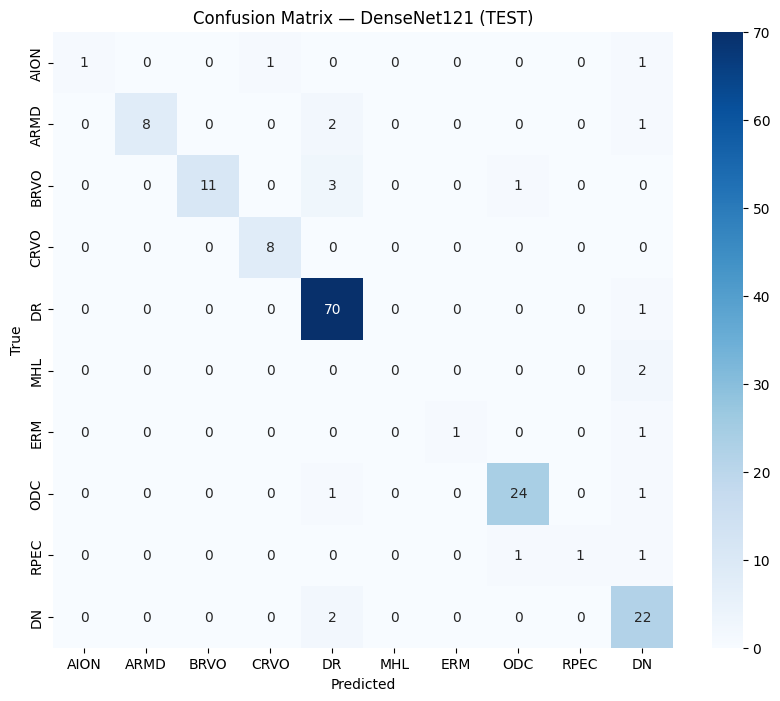


📌 Classification Report (TEST, DenseNet121):

              precision    recall  f1-score   support

        AION       1.00      0.33      0.50         3
        ARMD       1.00      0.73      0.84        11
        BRVO       1.00      0.73      0.85        15
        CRVO       0.89      1.00      0.94         8
          DR       0.90      0.99      0.94        71
         MHL       0.00      0.00      0.00         2
         ERM       1.00      0.50      0.67         2
         ODC       0.92      0.92      0.92        26
        RPEC       1.00      0.33      0.50         3
          DN       0.73      0.92      0.81        24

    accuracy                           0.88       165
   macro avg       0.84      0.65      0.70       165
weighted avg       0.89      0.88      0.87       165



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# ============================================
# 📌 CELL 2 — TEST ACCURACY + CONFUSION MATRIX + CLASSIFICATION REPORT
# ============================================

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torch

true_labels = []
pred_labels = []

with torch.no_grad():
    for imgs, labels in test_dl:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        out = best_model(imgs)
        preds = out.argmax(1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# ---------- Overall Test Accuracy ----------
test_acc = (true_labels == pred_labels).mean()
print(f"\n🔥 Test Accuracy: {test_acc:.4f}")

# ---------- Confusion Matrix ----------
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(10,8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=CLASSES,
    yticklabels=CLASSES,
    cmap="Blues"
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — DenseNet121 (TEST)")
plt.show()

# ---------- Classification Report ----------
print("\n📌 Classification Report (TEST, DenseNet121):\n")
print(classification_report(true_labels, pred_labels, target_names=CLASSES))


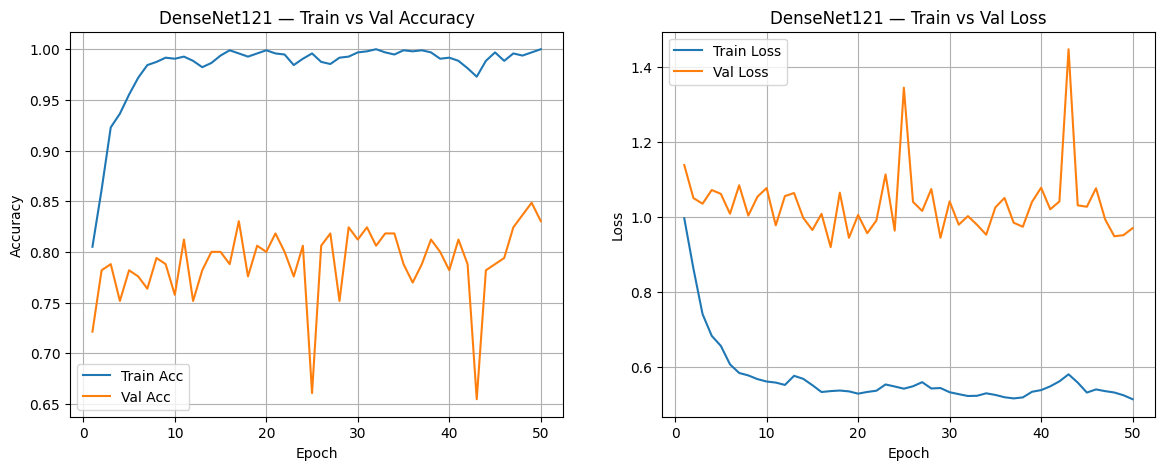

In [ ]:
# ============================================
# 📌 CELL 3 — TRAINING & VALIDATION CURVES
# ============================================

import matplotlib.pyplot as plt

# history = [(tr_loss, tr_acc, va_loss, va_acc), ...]
train_loss = [h[0] for h in history]
train_acc  = [h[1] for h in history]
val_loss   = [h[2] for h in history]
val_acc    = [h[3] for h in history]

epochs = range(1, len(history) + 1)

plt.figure(figsize=(14,5))

# ----- Accuracy curve -----
plt.subplot(1,2,1)
plt.plot(epochs, train_acc, label="Train Acc")
plt.plot(epochs, val_acc, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("DenseNet121 — Train vs Val Accuracy")
plt.legend()
plt.grid(True)

# ----- Loss curve -----
plt.subplot(1,2,2)
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("DenseNet121 — Train vs Val Loss")
plt.legend()
plt.grid(True)

plt.show()
